In [13]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

In [14]:
rho = 1
mu = 1
u_in = 1.5
D = 1
L = 10
tle = 10
v_i = -1.5
tau_0 = 10

In [15]:
geom = dde.geometry.Rectangle(xmin=[-L/2,-D/2],xmax=[L/2,D/2])

In [16]:
def upper_wall(X, on_boundary):
  on_upper_wall = np.logical_and(np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_upper_wall

def lower_wall(X, on_boundary):
  on_lower_wall = np.logical_and(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_lower_wall

def boundary_inlet(X,on_boundary):
  on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_inlet

def boundary_outlet(X,on_boundary):
  on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_outlet

In [17]:
bc_wall_u = dde.DirichletBC(geom, lambda X:v_i, upper_wall, component =0)
bc_wall_u = dde.DirichletBC(geom, lambda X:0., lower_wall, component =0)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., upper_wall, component =1)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., lower_wall, component =1)

bc_inlet_u = dde.DirichletBC(geom, lambda X:u_in, boundary_inlet, component =0)
bc_inlet_v = dde.DirichletBC(geom, lambda X:0., boundary_inlet, component =1)

bc_outlet_p = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =2)
bc_outlet_v = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =1)

In [18]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)
    # du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    # du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    # dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    # dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    # Definições para Bingham para componentes do tensor de tensão
    tau_xy = tau_0 + mu * (du_y + dv_x)
    tau_yx = tau_0 + mu * (dv_x + du_y)
    tau_xx = tau_0 + mu * (du_x + du_x)
    tau_yy = tau_0 + mu * (dv_y + du_y)

    # tau_diff = tau_xy - tau_0
    # H_tau = tf.where(tau_diff > 0, 1.0, 0.0)
    # dv_x = dde.grad.jacobian(Y, X, i=0, j=0) * H_tau
    # du_y = dde.grad.jacobian(Y, X, i=0, j=1) * H_tau
    
    # tau_xy = tau_0 + mu * (du_y + dv_x)
    # tau_yx = tau_0 + mu * (dv_x + du_y)
    # tau_xx = tau_0 + mu * (du_x + du_x)
    # tau_yy = tau_0 + mu * (dv_y + du_y)

    # Derivadas dos tensores de tensão
    dtau_xy_y = dde.grad.jacobian(tau_xy, X, i=0, j=1)
    dtau_yx_x = dde.grad.jacobian(tau_yx, X, i=0, j=0)
    dtau_xx_x = dde.grad.jacobian(tau_xx, X, i=0, j=0)
    dtau_yy_y = dde.grad.jacobian(tau_yy, X, i=0, j=1)

    # Equações de Navier-Stokes modificadas para incluir todos os tensores de tensão
    pde_u = rho * (Y[:,0:1] * du_x + Y[:,1:2] * du_y) + dp_x - dtau_yx_x - dtau_xx_x
    pde_v = rho * (Y[:,0:1] * dv_x + Y[:,1:2] * dv_y) + dp_y - dtau_xy_y - dtau_yy_y
    pde_cont = du_x + dv_y  # Equação de continuidade

    return [pde_u, pde_v, pde_cont]


In [19]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u,bc_wall_v,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                    num_domain = 5000,
                    num_boundary = 5000,
                    num_test = 10000)

<function matplotlib.pyplot.show(close=None, block=None)>

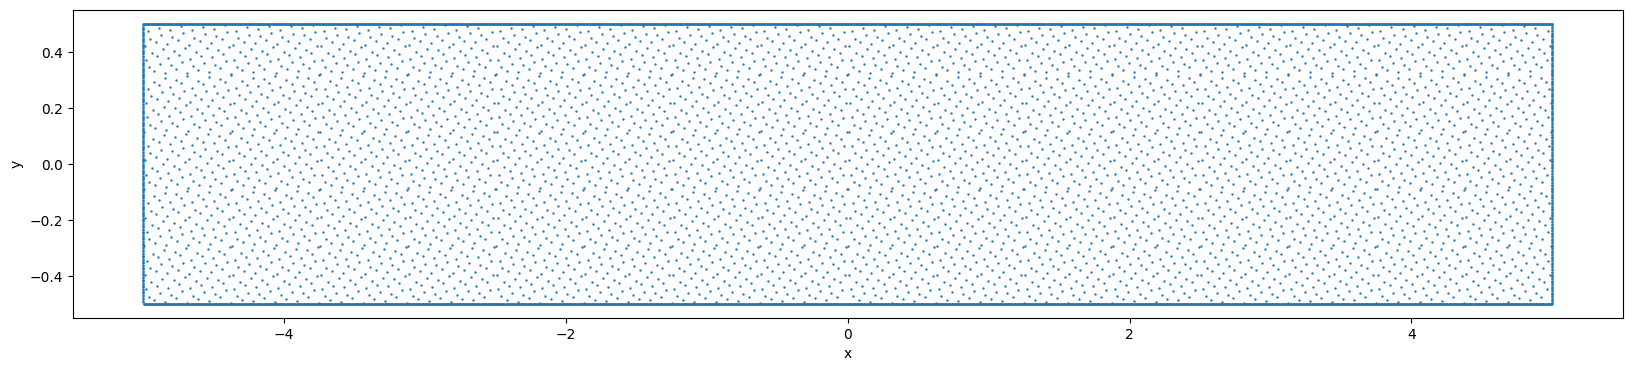

In [20]:
plt.figure(figsize=(20,4))
plt.scatter(data.train_x_all[:,0],data.train_x_all[:,1],s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show

In [21]:
net = dde.maps.FNN([2]+[64]*5+[3], "tanh","Glorot uniform")

In [22]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.069828 s



c:\Users\Pablo\AppData\Local\pypoetry\Cache\virtualenvs\deepxde-custom-4PBOT-FI-py3.10\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.338370 s



In [23]:
losshistory,train_state = model.train(epochs = 10000, display_every=100)

Training model...

0         [6.06e-02, 4.43e-02, 9.52e-02, 3.59e-01, 3.78e-01, 5.37e-01, 6.91e-01, 2.80e-02, 6.91e-01]    [6.31e-02, 4.80e-02, 1.02e-01, 3.59e-01, 3.78e-01, 5.37e-01, 6.91e-01, 2.80e-02, 6.91e-01]    []  
100       [1.31e-02, 4.69e-03, 1.22e-02, 9.77e-02, 3.09e-03, 7.34e-02, 1.99e-03, 6.68e-04, 8.53e-04]    [1.15e-02, 2.62e-03, 1.21e-02, 9.77e-02, 3.09e-03, 7.34e-02, 1.99e-03, 6.68e-04, 8.53e-04]    []  
200       [5.55e-03, 1.49e-03, 5.98e-03, 8.61e-02, 2.17e-03, 6.69e-02, 3.97e-03, 1.29e-04, 4.63e-04]    [4.47e-03, 9.10e-04, 5.58e-03, 8.61e-02, 2.17e-03, 6.69e-02, 3.97e-03, 1.29e-04, 4.63e-04]    []  
300       [4.65e-03, 1.35e-03, 6.70e-03, 1.04e-01, 1.91e-03, 4.14e-02, 5.39e-03, 2.03e-03, 3.22e-04]    [3.56e-03, 1.16e-03, 6.06e-03, 1.04e-01, 1.91e-03, 4.14e-02, 5.39e-03, 2.03e-03, 3.22e-04]    []  
400       [2.86e-03, 1.06e-03, 8.10e-03, 7.80e-02, 2.23e-03, 5.03e-02, 5.77e-03, 1.04e-04, 2.80e-04]    [2.04e-03, 7.62e-04, 7.14e-03, 7.80e-02, 2.23e-03, 5.03e-02, 5.77

In [1]:
import matplotlib.pyplot as plt

plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u", "bc_wall_v", "bc_inlet_u", "bc_inlet_v", "bc_outlet_p", "bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.show()

NameError: name 'np' is not defined

In [25]:
dde.optimizers.config.set_LBFGS_options(maxiter = 1000)
model.compile("L-BFGS")
losshistory,train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False , isplot = False)

Compiling model...
'compile' took 1.951507 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [4.68e-03, 3.42e-03, 3.11e-03, 2.91e-02, 2.97e-03, 1.46e-02, 1.03e-03, 2.64e-04, 1.24e-04]    [5.48e-03, 3.22e-03, 3.85e-03, 2.91e-02, 2.97e-03, 1.46e-02, 1.03e-03, 2.64e-04, 1.24e-04]    []  
11000     [3.95e-03, 4.53e-04, 3.01e-03, 2.35e-02, 3.58e-03, 9.95e-03, 8.42e-04, 4.86e-05, 2.98e-05]    [3.95e-03, 4.53e-04, 3.01e-03, 2.35e-02, 3.58e-03, 9.95e-03, 8.42e-04, 4.86e-05, 2.98e-05]        
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  Objective function value: 0.045200
  Number of iterations: 1000
  Number of functions evaluations: 1017
11017     [3.84e-03, 4.52e-04, 3.01e-03, 2.33e-02, 3.51e-03, 1.02e-02, 8.16e-04, 3.36e-05, 2.83e-05]    [4.57e-0

In [26]:
samples= geom.random_points(500000)
result = model.predict(samples)

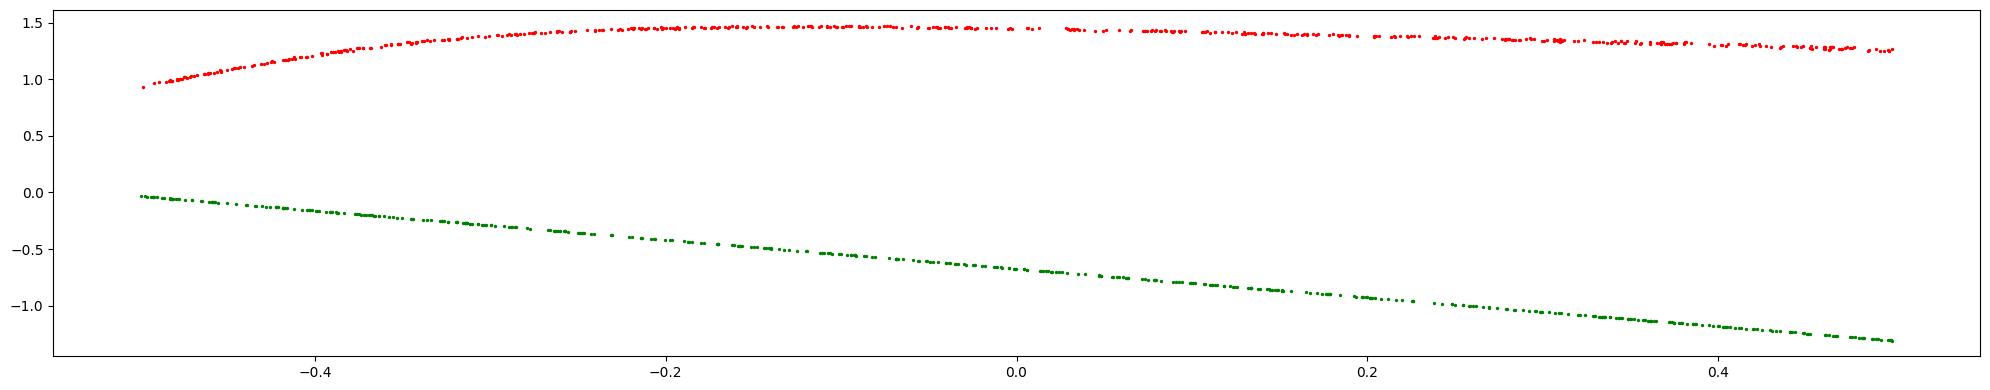

In [27]:
color_legend=[[0,1.5],[-0.3,0.3],[0,35]]
# for idx in range(3):
plt.figure(figsize=(20,4))
mask = np.where((samples[:,0] > 4.9) & (samples[:,0] < 4.91))
plt.scatter(samples[mask,1], result[mask,0], c='green',s=2)
mask = np.where((samples[:,0] < -4.9) & (samples[:,0] > -4.91))
plt.scatter(samples[mask,1], result[mask,0], c='red',s=2)
plt.tight_layout()
plt.show()

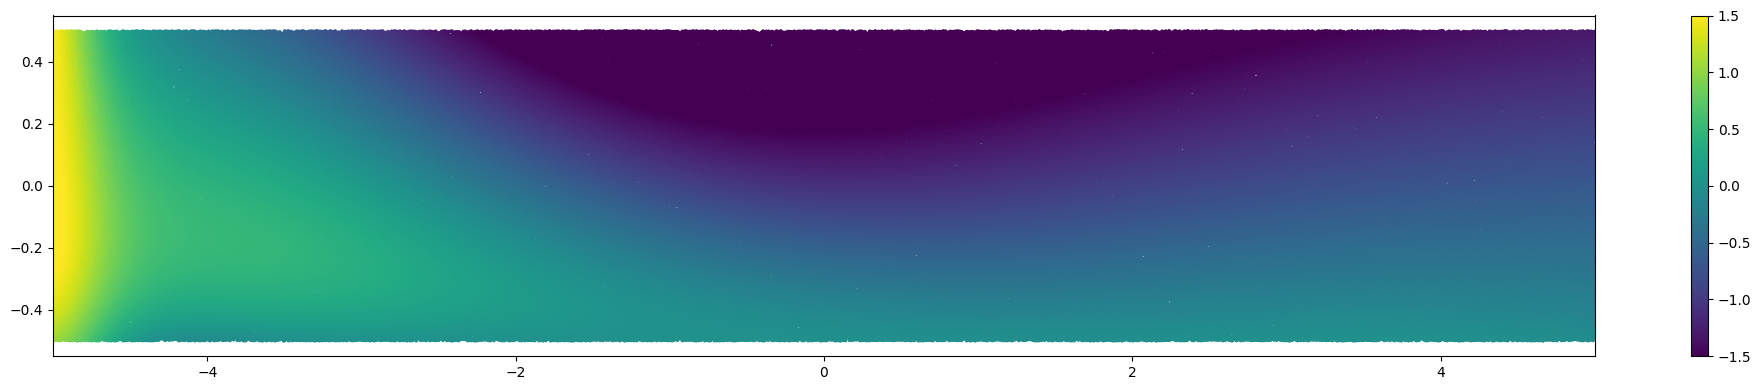

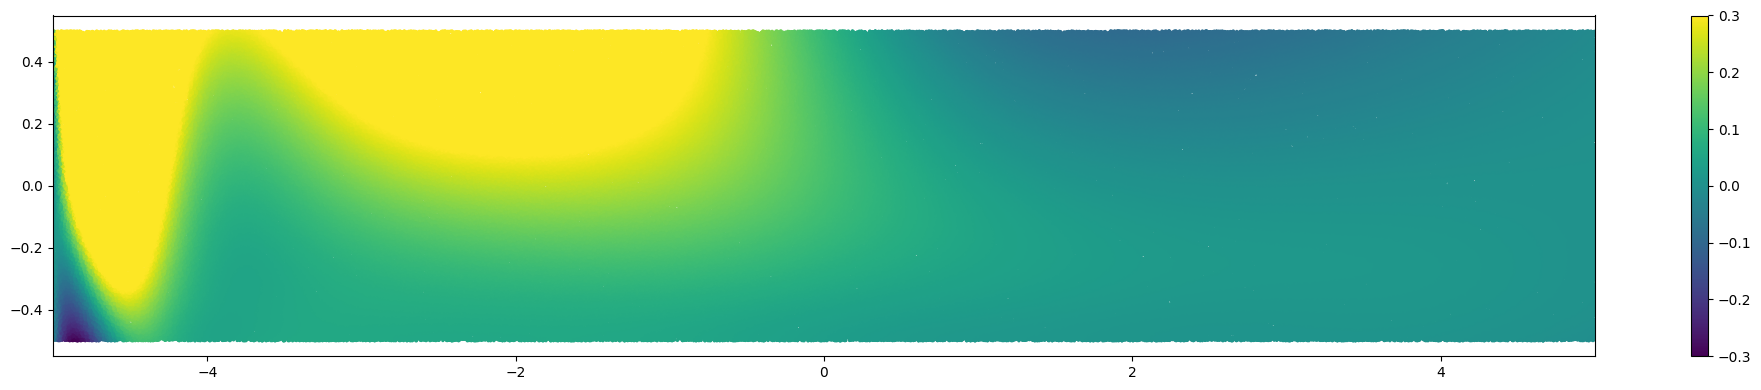

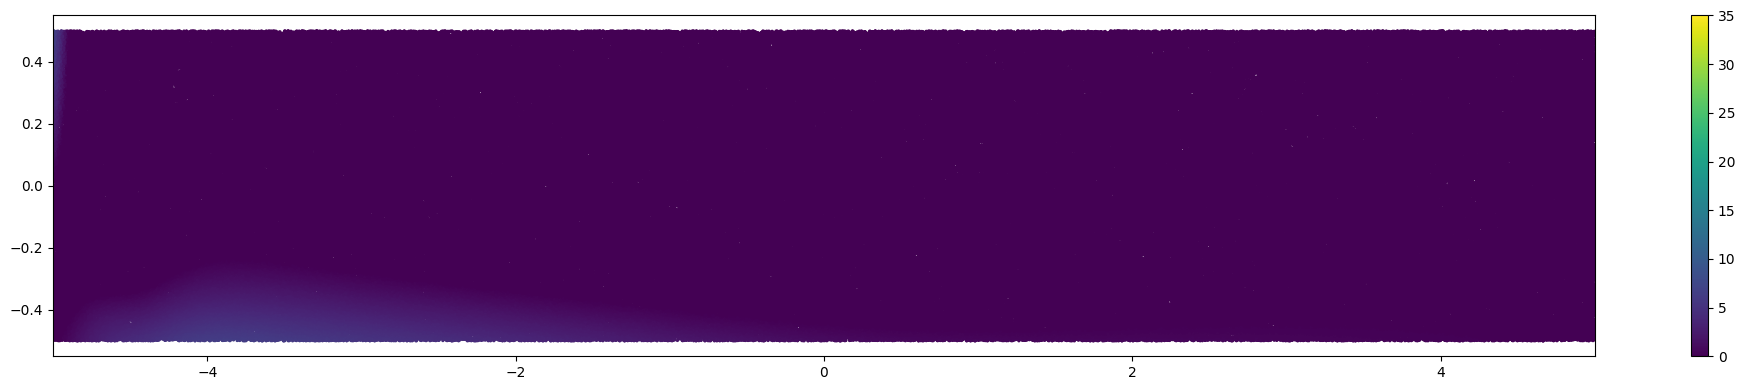

In [28]:
color_legend=[[-1.5,1.5],[-0.3,0.3],[0,35]]
for idx in range(3):
  plt.figure(figsize=(20,4))
  plt.scatter(samples[:,0], samples[:,1], c=result[:,idx], cmap='viridis',s=2)
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((0-D/2,D-D/2))
  plt.xlim((0-L/2,L-L/2))
  plt.tight_layout()
  plt.show()